<a href="https://colab.research.google.com/github/rohandawar/-daysforcoding/blob/main/Text_Extraction_From_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook, I am trying to extract text from a image uaing python Tesseract Library.

The following actions would be performed in this notebook.

1. Install Testseract Library
2. Get/load the Data (Image from which Data needs to be extracted) 




In [1]:
from IPython.display import clear_output

In [2]:
!pip install pytesseract
clear_output()

In [3]:
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev
clear_output()

In [4]:
# Import Libs
from PIL import Image
import pytesseract
import cv2
import numpy as np
import re
import requests
from pytesseract import Output

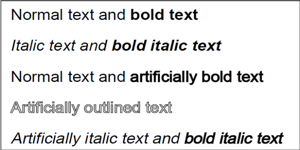

In [5]:
# Read the image from URL (In this case I searched the image on internet & then uploaded on Post Image)
image = Image.open(requests.get('https://i.postimg.cc/zfNp89ZM/Sample-Image-Text.png', stream=True).raw)
image = image.resize((300,150))
image.save('sample.png')
image

In [6]:
# Simply extracting the text
custom_config = r'-l eng --oem 3 --psm 6'
text = pytesseract.image_to_string(image,config = custom_config)
print(text)

Normal text and bold text

Italic text and bold italic text

Normal text and artificially bold text
Artificially outlined text

Artificially italic text and bold italic text



In [7]:
# Extracting text from image and removing  
try:
  text = pytesseract.image_to_string(image, lang='eng')
  character_to_remove = "!()@-*>+-/,'#%$&^_~"
  new_string = text
  for character in character_to_remove:
    new_string = new_string.replace(character,"")
  print(new_string)
except IOError as e:
  print('Error (%s).'%e)

 

Normal text and bold text

Italic text and bold italic text
Normal text and artificially bold text
Artificially outlined text

Artificially italic text and bold italic text



In [8]:
# Now we will perform opencv operations to get text from complex images
image = cv2.imread('sample.png')

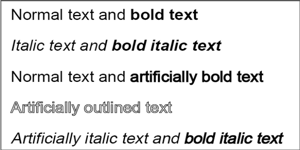

In [9]:
# Get grayscale image
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = get_grayscale(image)
Image.fromarray(gray)

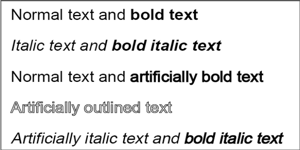

In [10]:
# noise removal
def remove_noise(image):
  return cv2.medianBlur(image,5)

noise = remove_noise(gray)
Image.fromarray(gray)

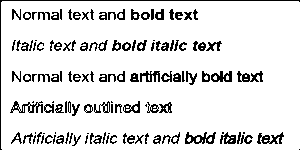

In [11]:
# Threshold
def thresholding(image):
  return cv2.threshold(image,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = thresholding(gray)
Image.fromarray(thresh)

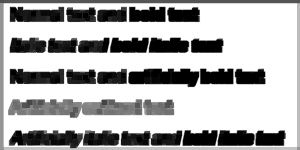

In [13]:
# erode
def erode(image):
  kernel = np.ones((5,5), np.uint8)
  return cv2.erode(image, kernel, iterations = 1)

erode = erode(gray)
Image.fromarray(erode)

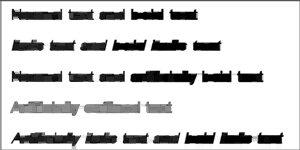

In [14]:
#Morphology
def opening(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.morphologyEx(image,cv2.MORPH_OPEN, kernel)
opening = opening(gray)
Image.fromarray(opening)

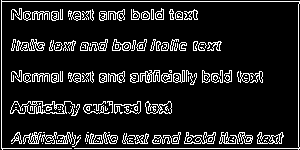

In [15]:
# Canny edge detection
def canny(image):
  return cv2.Canny(image, 100,200)
canny = canny(gray)
Image.fromarray(canny)

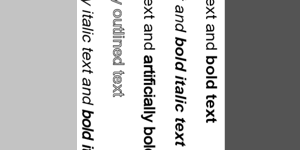

In [17]:
# Skew Correction
def deskew(image):
  coords = np.column_stack(np.where(image>0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle <-45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h,w) = image.shape[:2]
  center = (w//2, h//2)
  M = cv2.getRotationMatrix2D(center, angle,1.0)
  rotated = cv2.warpAffine(image, M, (w,h), flags= cv2.INTER_CUBIC, borderMode = cv2.BORDER_REPLICATE)
  return rotated
rotated = deskew(gray)
Image.fromarray(rotated)

In [20]:
# Template Matching
def match_template(image, template):
  return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
match = match_template(gray,gray)
match

array([[1.]], dtype=float32)

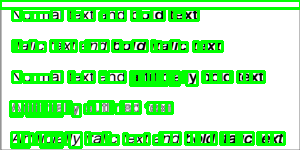

In [21]:
# Drawing rectangle around text
img = cv2.imread('sample.png')
h,w,c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
  b = b.split(' ')
  img = cv2.rectangle(img, (int(b[1]), h-int(b[2])), (int(b[3]), h-int(b[4])), (0,255,0),2)
Image.fromarray(img)


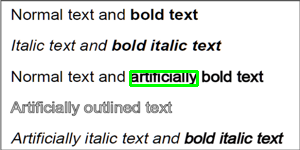

In [23]:
# Drawing pattern on specific word
img = cv2.imread('sample.png')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

data_pattern = 'artificially'
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
    	if re.match(data_pattern, d['text'][i]):
	        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
	        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
Image.fromarray(img)